# Анализ данных сервиса аренды самокатов GoFast

В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. Задача - проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Импортируем библиотеки, которые понадобятся в ходе работы:

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt 
import datetime
import calendar
import seaborn
from scipy import stats as st
from math import sqrt
from importlib import reload

#### Шаг 1. Загрузка данных

Имеются 3 массива данных: `users_go.csv`, `rides_go.csv`, `subscriptions_go.csv`. Сохраним их в 3 отдельные переменные `data_users`, `data_rides`, `data_subscriptions` соответственно.

In [2]:
# Загрузим 3 исходных массива данных о пользователях, их поездках и подписках:
data_users = pd.read_csv('/datasets/users_go.csv')
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

**Информация о пользователях**

In [3]:
# Выведем первые несколько строк массива и общую информацию для данных о пользователях услуг:
display(data_users.head(10))
data_users.info()

data_users.isna().sum()
# Пропуски в данных отсутствуют

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Мы видим, что в нашем массиве данных имеются 1565 наблюдений со следующими столбцами: `user_id`, `name`, `age`, `city`, `subscription_type` с информацией об уникальном идентификаторе пользователя услуг, его имене, возрасте, городе и типе подписке соответственно.

Затем мы вывели общую информацию о датасете, увидели, что типы данных в порядке, пропуски отсутствуют; можем переходить к следующему массиву данных о поездках.


**Информация о поездках**

In [4]:
# Выведем первые несколько строк массива и общую информацию для данных о поездках пользователях:
display(data_rides.head(10))
data_rides.info()
data_rides.isna().sum()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


user_id     0
distance    0
duration    0
date        0
dtype: int64

Теперь мы имеем датафрейм со следующими столбцами: `user_id`, `distance`, `duration`, `date`, в которых хранятся данные о том же уникальном идентификаторе пользователя; расстоянии, которое он(а) проехал в текущей сессии (в метрах); продолжительности сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»; дате совершения поездки.
В итоге мы получили 18068 наблюдений без пропусков, однако, выведя общую информацию о датафрейме, видим, что тип данных с датами не в порядке (недочет будет исправлен в Шаге 2 на этапе предобработки данных).

**Информация о подписках**

In [5]:
display(data_subscriptions.head())
data_subscriptions.info()
data_subscriptions.isna().sum()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Имеется всего 2 варианта подписки, пропуски отсутствуют. В датафрейме даны следующие столбцы: `subscription_type` о типе подписки (free - без подписки, ultra - с подпиской), `minute_price` о стоимости одной минуты поездки по данной подписке, `start_ride_price` о стоимость начала поездки, `subscription_fee` о стоимости ежемесячного платежа. С типами данных все в порядке, можно идти дальше.

На Шаге 1 мы загрузили и исследовали предварительную информацию о предоставленных данных. Очевидно, что необходима предобработка в части корректировки типов данных. Кроме того, не лишним будет проверить и наличие дубликатов.

#### Шаг 2. Предобработка данных

In [6]:
# Приведем столбец date к типу даты Pandas
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%dT%H:%M:%S')
data_rides.info()
# Проверили, формат изменен

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [7]:
# Создадим новый столбец с номером месяца:
data_rides['month']=data_rides['date'].dt.strftime('%-m')
# Проверим на всякий случай уникальные значения:
data_rides['month'].unique()


array(['1', '4', '8', '10', '11', '12', '3', '6', '7', '2', '5', '9'],
      dtype=object)

In [8]:
# Проверим, за какой период нам предоставлены данные
data_rides['year']=data_rides['date'].dt.strftime('%Y')
data_rides['year'].unique()

array(['2021'], dtype=object)

Уникальные значения показывают, что данные имеются только за 2021 год. 

Проверим далее наши датасеты на наличие дубликатов.

In [9]:
# Проверим наличие явных дубликатов в массиве данных о пользователях:
data_users['user_id'].unique()
data_users.duplicated()
data_users.duplicated().sum()

31

Увидели, что мы имеем 31 явный дубликат: строки, которые полностью повторяются. Удалим их:

In [10]:
# Удалим строки, которые полностью дублируют друг друга, их 31:
data_users=data_users.drop_duplicates() 

# Проверим количество явных дубликатов:
data_users.duplicated().sum()
#data_users.info()
# Теперь у нас 1534 наблюдения 

# Проверим на всякий случай количество уникальных значений столбца user_id:
data_users['user_id'].nunique()

1534

В массиве данных о пользователях с помощью кода `data_users.duplicated().sum()` были обнаружены полностью дублирующие друг друга строки (в количестве 31 штуки). После их удаления у нас осталось 1534 наблюдения.

Далее с помощью кода `data_users['user_id'].nunique()` на всякий случай мы проверили количество уникальных значений столбца user_id на предмет ошибки: в случае если под одним и тем же user_id указаны данные о разных пользователях

Количество уникальных `user_id` равно количеству оставшихся наблюдений, поэтому ошибок нет, можем идти дальше и анализировать данные о поездках.

In [11]:
# Найдем явные дубликаты для данных о поездках:
data_rides.duplicated()
data_rides.duplicated().sum()
# Явных дубликатов нет

# Можем также проверить, для всех ли user_id есть информация о поездках:
data_rides['user_id'].nunique()
# Уникальных значений user_id 1534 - данные о поездках есть для всех пользователей в нашей выборке
data_rides['distance'].nunique()
data_rides['duration'].nunique()

17974

Явных дубликатов в массиве данных о поездках не оказалось, данные о поездках есть для всех пользователей в нашей выборке. В нашей выборке также есть совпадающие данные по длительности поездок, но учитывая, что все данные о дистанциях уникальны, то удалять строки с повторяющимися данными о длительности поездок не стоит.

Массив данных о подписках совсем невелик, наличие дубликатов можно проверить вручную: они отсутствуют. Данный массив дальнейшей предобработки на данном этапе не требует.

На Шаге 2 мы предобработали данные: изменили тип данных, где это было необходимо ( а именно привели привели столбец `date` к типу даты Pandas); создали новый столбец с номером месяца на основе столбца `date` (это понадобится для дальнейшего анализа, особенно в части вычисления помесячной выручки); оздали новый столбец с обозначением года на основе столбца `date` (чтобы понять, за какой период были предоставлены данные и для недопущения отображения некорректных данных по ежемесячной выручке); проверили наличие пропущенных значений (в том числе и на Шаге 1) и дубликатов в датафреймах (полностью повторяющиеся строки были удалены).

#### Шаг 3. Исследовательский анализ данных

**Частота встречаемости городов**

[Text(0.5, 0, 'Город'),
 Text(0, 0.5, 'Количество пользователей, ед.'),
 Text(0.5, 1.0, 'Частота встречаемости городов')]

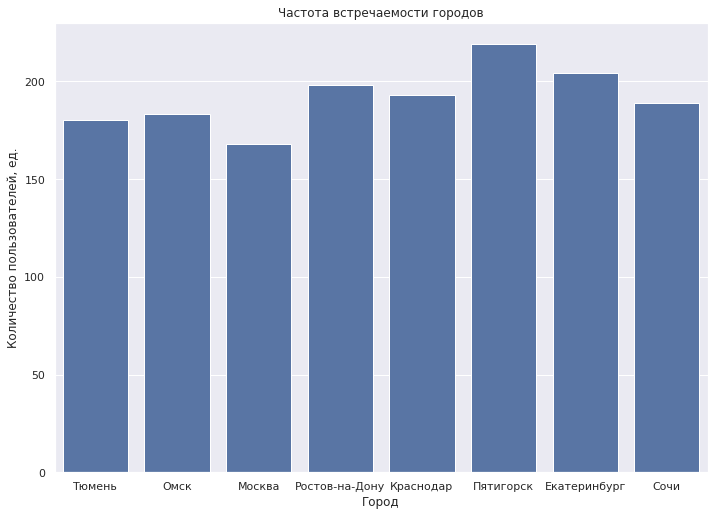

In [12]:
seaborn.set(rc={'figure.figsize':(11.7, 8.27)})
ax=seaborn.countplot(x='city', data=data_users, color='b')
ax.set(xlabel='Город', ylabel='Количество пользователей, ед.', title='Частота встречаемости городов')

Частота встречаемости городов примерно одинаковая, при этом наиболее часто встречающийся в нашей выборке город - Пятигорск, а наименее популярной услуга оказалось в Москве.

**Соотношение пользователей с подпиской и без подписки**

[Text(0.5, 0, 'Тип подписки'),
 Text(0, 0.5, 'Количество пользователей, ед.'),
 Text(0.5, 1.0, 'Сравнение количества пользователей с подпиской и без подписки')]

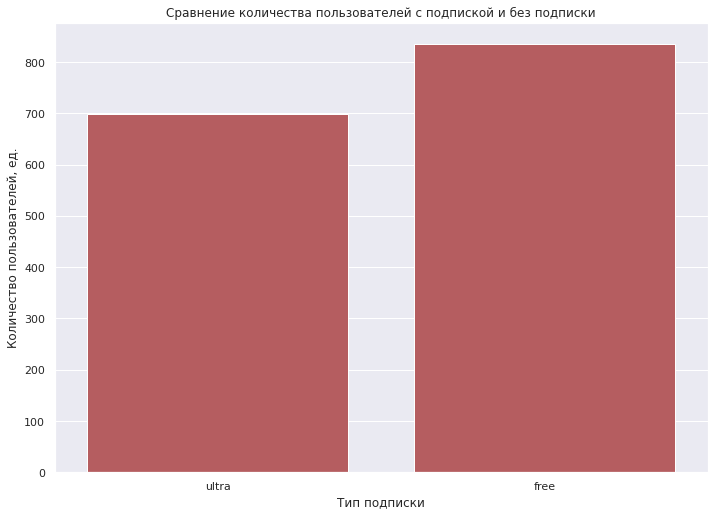

In [13]:
ax=seaborn.countplot(x='subscription_type', data=data_users, color='r')
ax.set(xlabel='Тип подписки', ylabel='Количество пользователей, ед.', title='Сравнение количества пользователей с подпиской и без подписки')

Видно, что чаще встречаются пользователи без подписки и их более 800, а пользователей с подпиской около 700.

**Возраст пользователей**

Text(0, 0.5, 'Частота')

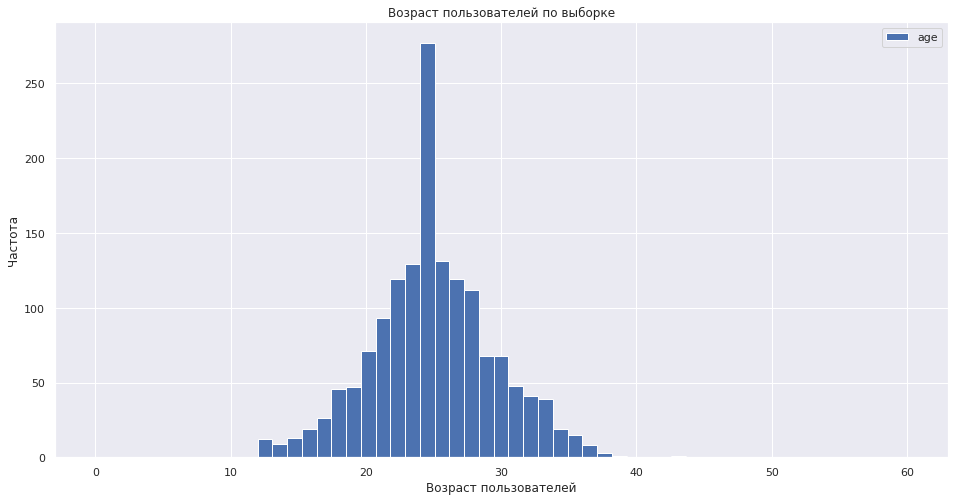

In [14]:
ax=data_users.plot(y='age', kind='hist', bins=55, grid=True, range=(0, 60), figsize=(16,8), title='Возраст пользователей по выборке')
ax.set_xlabel("Возраст пользователей")
ax.set_ylabel("Частота")

Наиболее популярны услуги GoFast среди пользователей чуть старше 20 и немного моложе 30 лет; особо популярны услуги среди пользователей возрастом примерно 25 лет.

**Расстояние, которое пользователь преодолел за одну поездку**

Text(0, 0.5, 'Частота')

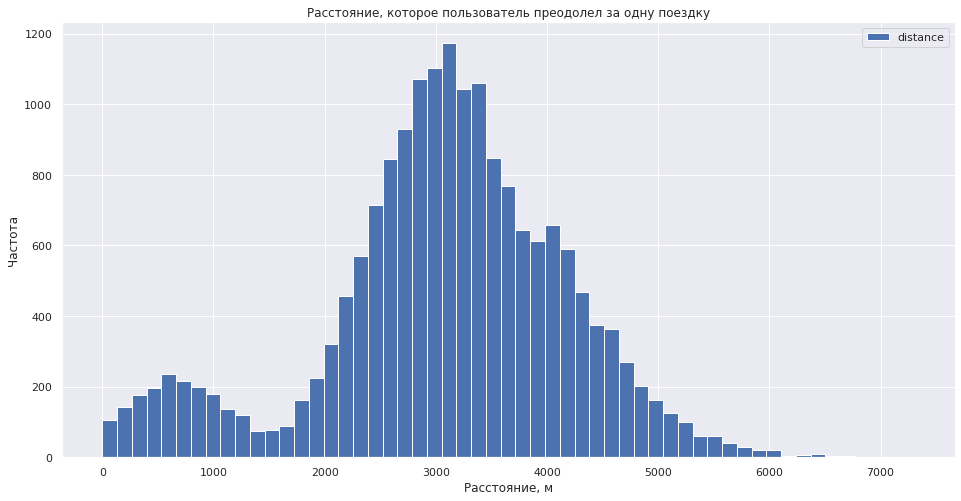

In [15]:
data_rides.describe()
ax=data_rides.plot(y='distance', kind='hist', bins=55, grid=True, range=(0, 7300), figsize=(16,8), title='Расстояние, которое пользователь преодолел за одну поездку')
ax.set_xlabel("Расстояние, м")
ax.set_ylabel("Частота")

Дистанции за одну поездку в промежутке от около 2,5 до 4 км оказались самыми популярными в нашей выборке.

**Продолжительность поездок**

Text(0, 0.5, 'Частота')

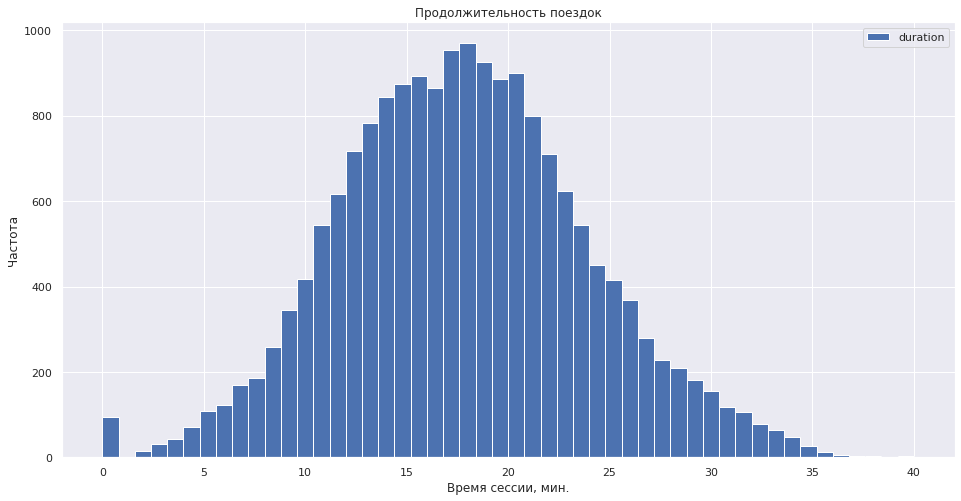

In [16]:
ax=data_rides.plot(y='duration', kind='hist', bins=50, grid=True, range=(0, 40), figsize=(16,8), title='Продолжительность поездок')
ax.set_xlabel("Время сессии, мин.")
ax.set_ylabel("Частота")

Наиболее часто встречающаяся продолжительность поездок в нашей выборке находится в диапазоне от более 10 до менее 25 минут.

#### Шаг 4. Объединение данных

**Объединенные данные о пользователях, поездках и подписках в одном датафрейме**

In [17]:
data_united = data_users.merge(data_rides, on='user_id', how='left')
data_united
data_final_united = data_united.merge(data_subscriptions, on ='subscription_type', how='left')
data_final_united

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,2021,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,2021,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,2021,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,2021,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,2021,8,50,0


**Таблица с данными о пользователях без подписки**

In [18]:
without_subscription = data_final_united.query('subscription_type == "free"')
without_subscription

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,2021,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,2021,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,2021,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,2021,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,2021,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,2021,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,2021,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,2021,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,2021,8,50,0


**Таблица с данными о пользователях с подпиской**

In [19]:
with_subscription = data_final_united.query('subscription_type == "ultra"')
with_subscription 

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,2021,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,2021,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,2021,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,2021,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,2021,6,0,199


**Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий**

Text(0, 0.5, 'Частота')

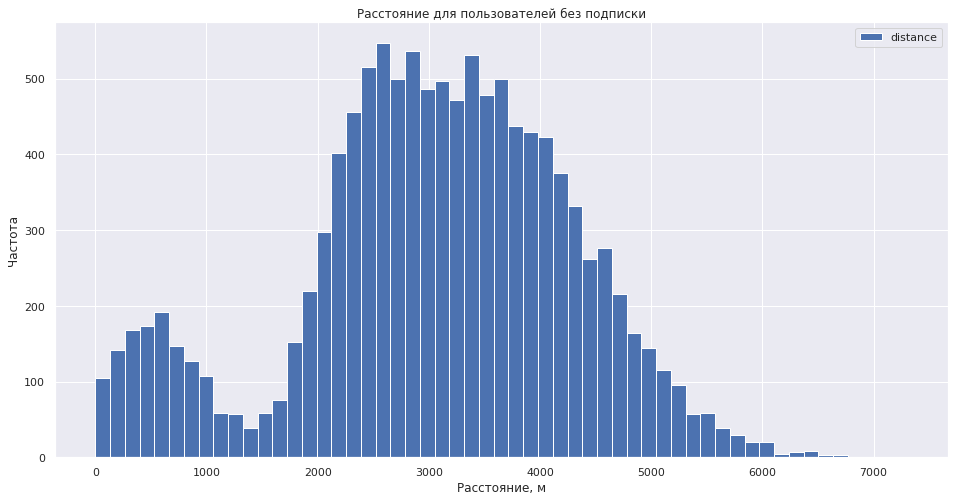

In [20]:
# Построим гистограмму о расстоянии для пользователей без подписки:
ax=without_subscription.plot(y='distance', kind='hist', bins=55, grid=True, range=(0, 7300), figsize=(16,8), title='Расстояние для пользователей без подписки')
ax.set_xlabel("Расстояние, м")
ax.set_ylabel("Частота")

Text(0, 0.5, 'Частота')

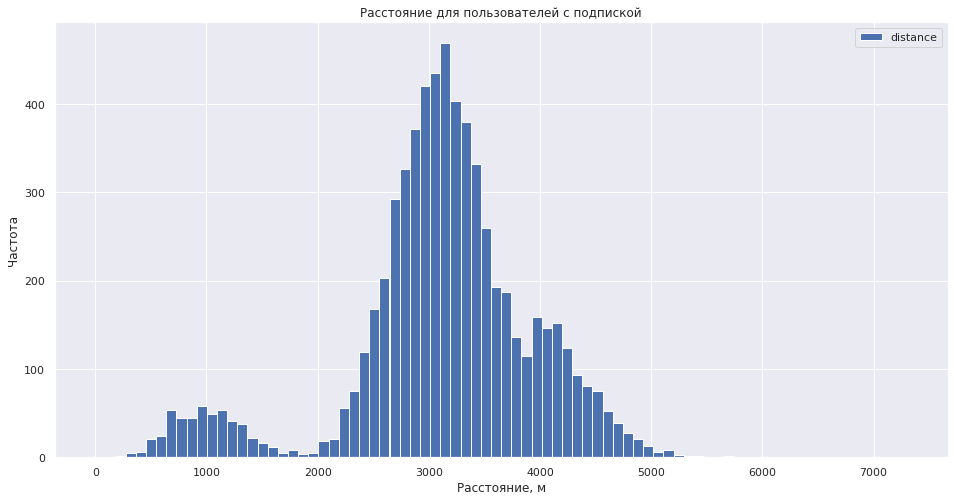

In [21]:
# Построим гистограмму о расстоянии для пользователей с подпиской:
ax=with_subscription.plot(y='distance', kind='hist', bins=80, grid=True, range=(0, 7300), figsize=(16,8), title='Расстояние для пользователей с подпиской')
ax.set_xlabel("Расстояние, м")
ax.set_ylabel("Частота")

Наиболее часто встречающиеся расстояния за сессию среди пользователей без подписки: от 2 до чуть менее 4,5 км.

Аналогичный показатель для пользователей с подпиской: от чуть более 2,5 до примерно 3,5 км. 

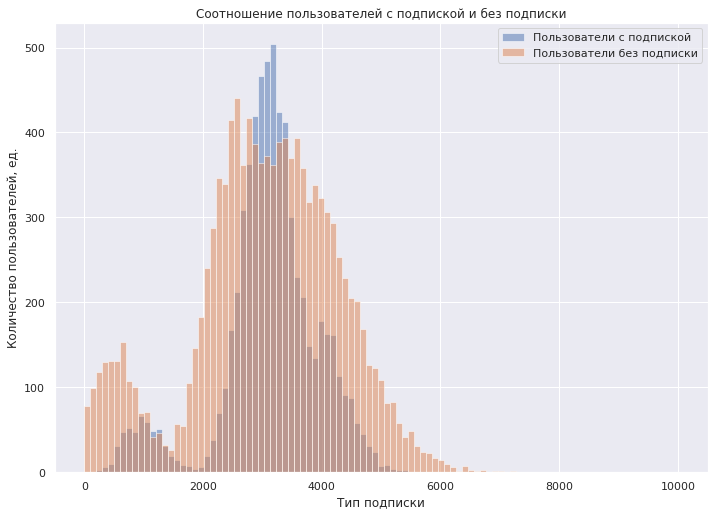

In [22]:
# Представим 2 вышеупомянутых графика на одном:

bins = numpy.linspace(0, 10000, 100)
plt=reload(plt)
plt.hist(with_subscription['distance'], bins, alpha=0.5, label='Пользователи с подпиской')
plt.hist(without_subscription['distance'], bins, alpha=0.5, label='Пользователи без подписки')
plt.legend(loc='upper right')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей, ед.')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

**Продолжительность поездок**

Text(0, 0.5, 'Частота')

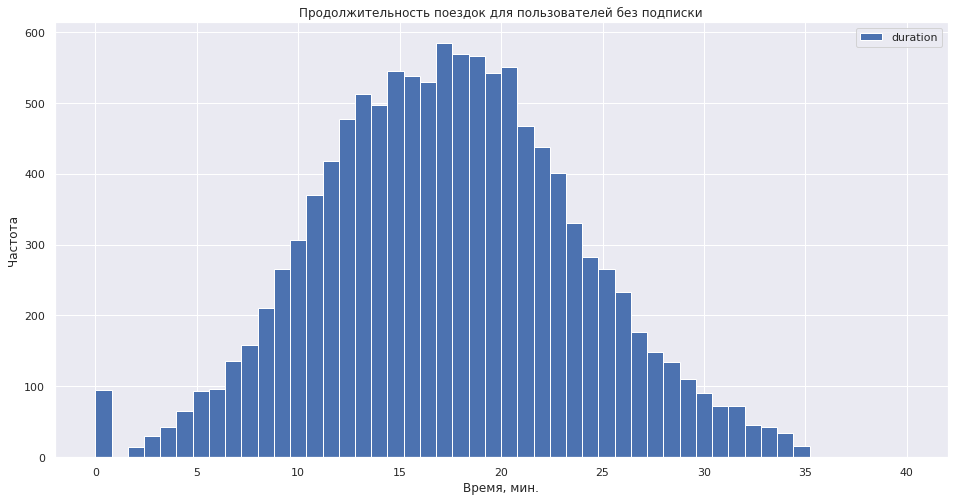

In [23]:
# Построим гистограмму о времени для пользователей без подписки:
ax=without_subscription.plot(y='duration', kind='hist', bins=50, grid=True, range=(0, 40), figsize=(16,8), title='Продолжительность поездок для пользователей без подписки')
ax.set_xlabel("Время, мин.")
ax.set_ylabel("Частота")

Text(0, 0.5, 'Частота')

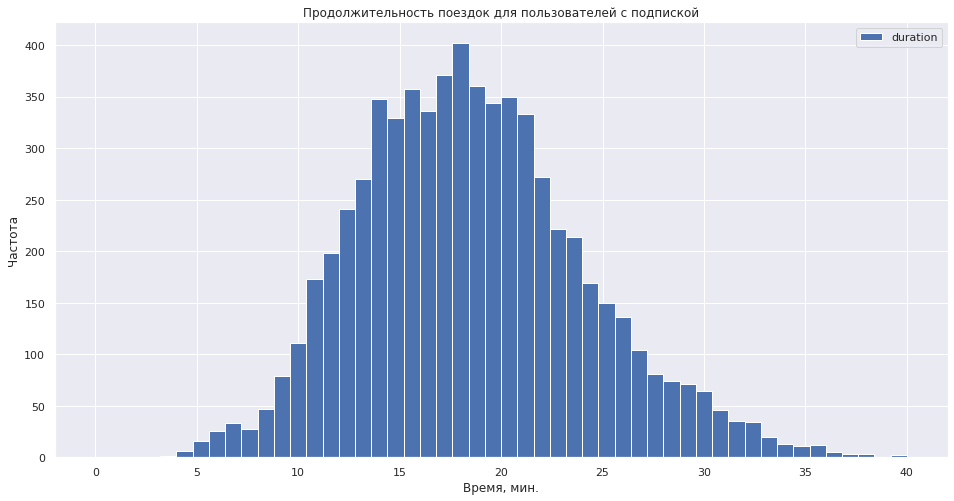

In [24]:
# Построим гистограмму о времени для пользователей с подпиской:
ax=with_subscription.plot(y='duration', kind='hist', bins=50, grid=True, range=(0, 40), figsize=(16,8), title='Продолжительность поездок для пользователей с подпиской')
ax.set_xlabel("Время, мин.")
ax.set_ylabel("Частота")

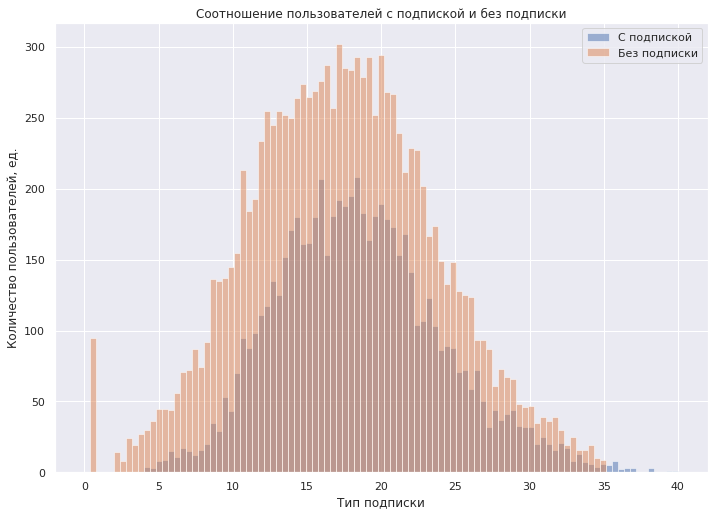

In [25]:
# Представим 2 вышеупомянутых графика на одном:
bins = numpy.linspace(0, 40, 100)

plt.hist(with_subscription['duration'], bins, alpha=0.5, label='С подпиской')
plt.hist(without_subscription['duration'], bins, alpha=0.5, label='Без подписки')
plt.legend(loc='upper right')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей, ед.')
plt.title('Соотношение пользователей с подпиской и без подписки')

plt.show()

Наиболее часто встречающиеся значения по времени сессии среди пользователей без подписки находятся в диапазоне примерно от 10 до 25 минут.

Наиболее часто встречающиеся значения по времени сессии среди пользователей с подпиской находятся в диапазоне примерно от чуть более 10 до чуть менее 25 минут. В отличие от первой категории, есть пользователи, время сессии которых превысило 35 минут, но относительно нашей выборки их очень мало.

#### Шаг 5. Подсчёт выручки

In [26]:
data_final_united

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,2021,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,2021,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,2021,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,2021,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,2021,8,50,0


**Датафрейм с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц**

In [27]:
# Создадим датафрейм с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц.
pivot = data_final_united.pivot_table(index=['user_id', 'month'], values = ['distance', 'duration'], aggfunc = ['sum', 'count']).reset_index()
pivot.columns = ['user_id', 'month', 'distance', 'duration', 'session_quantity', 'session_quantity_dup']
pivot

# Удалим повторяющийся столбец
del pivot[pivot.columns[5]]
pivot


,user_id,month,distance,duration,session_quantity
0,1,1,7027.511294,41.416640,2
1,1,10,5809.911100,31.578017,2
2,1,11,7003.499363,53.397424,3
3,1,12,6751.629942,27.203912,2
4,1,4,754.159807,6.232113,1
...,...,...,...,...,...
11326,1534,2,2103.914120,13.425579,1
11327,1534,4,3434.290912,14.366248,1
11328,1534,6,3409.468534,24.812678,2
11329,1534,8,7622.453034,47.205960,2


**Округлим продолжительность каждой поездки с помощью метода «потолок» библиотеки numpy**

In [28]:
pivot['duration'] = numpy.ceil(pivot['duration']) 
pivot

,user_id,month,distance,duration,session_quantity
0,1,1,7027.511294,42.0,2
1,1,10,5809.911100,32.0,2
2,1,11,7003.499363,54.0,3
3,1,12,6751.629942,28.0,2
4,1,4,754.159807,7.0,1
...,...,...,...,...,...
11326,1534,2,2103.914120,14.0,1
11327,1534,4,3434.290912,15.0,1
11328,1534,6,3409.468534,25.0,2
11329,1534,8,7622.453034,48.0,2


**Добавляем столбец с помесячной выручкой, которую принёс каждый пользователь**

In [29]:
pivot['subscription_type']=data_final_united['subscription_type']
pivot['revenue_per_month']=(199+pivot['duration']*6)*(pivot['subscription_type']=='ultra')+(pivot['session_quantity']*50+pivot['duration']*8)*(pivot['subscription_type']=='free')
pivot

,user_id,month,distance,duration,session_quantity,subscription_type,revenue_per_month
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,10,5809.911100,32.0,2,ultra,391.0
2,1,11,7003.499363,54.0,3,ultra,523.0
3,1,12,6751.629942,28.0,2,ultra,367.0
4,1,4,754.159807,7.0,1,ultra,241.0
...,...,...,...,...,...,...,...
11326,1534,2,2103.914120,14.0,1,free,162.0
11327,1534,4,3434.290912,15.0,1,free,170.0
11328,1534,6,3409.468534,25.0,2,free,300.0
11329,1534,8,7622.453034,48.0,2,free,484.0


#### Шаг 6. Проверка гипотез

**Тратят ли пользователи с подпиской больше времени на поездки?**

In [30]:
# Воспользуемся следующим методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам:
# H0: в среднем пользователи с подпиской тратят на поездку не больше или равно времени, чем пользователи без подписки
# H1: в среднем пользователи с подпиской тратят на поездку больше времени, чем пользователи без подписки

alpha=0.05
result=st.ttest_ind(with_subscription ['duration'], without_subscription['duration'], alternative='greater')
print(result.pvalue)

if result.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что в среднем пользователи с подпиской тратят на поездку не больше времени, чем пользователи без подписки; есть основания говорить о том, что пользователи с подпиской тратят больше времени на поездки в среднем на одну поездку.

**Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

In [31]:
# H0: в среднем пользователи с подпиской за поездку проезжают расстояние равное или не больше оптимального значения 3130 метров
# H1: в среднем пользователи с подпиской превышают оптимальное значение 3130 метров
# Воспользуемся следующим методом проведения одностороннего теста:

parameter=3130

alpha = 0.05 

results = st.ttest_1samp(
    with_subscription['distance'], 
    parameter, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')    

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Есть основания полагать, что среднее расстояние пользователей с подпиской за одну поездку не превышает оптимальное 3130

**Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**

In [32]:
# H0: в среднем пользователи с подпиской приносят ежемесячную выручку не больше или равную той, которую приносят пользователи с подпиской
# H1: в среднем пользователи с подпиской приносят ежемесячную выручку больше, чем пользователи с подпиской
# Проведем правосторонний тест:
alpha=0.05
result=st.ttest_ind(pivot[pivot['subscription_type']=='ultra']['revenue_per_month'], pivot[pivot['subscription_type']=='free']['revenue_per_month'], alternative='greater')
print(result.pvalue)

if result.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')


8.768770088188501e-57
Отвергаем нулевую гипотезу


Есть основания полагать, что пользователи с подпиской приносят бОльшую ежемесячную выручку

**Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

Если мы анализируем одну генеральную совокупность, с которой произошли некоторые изменения, то в этом случае мы будем проверять, равны ли средние совокупности до и после произошедшего изменения (обновления серверов). Чтобы проверить гипотезу о равенстве средних двух генеральных совокупностей для зависимых (парных) выборок в Python, применяется метод `scipy.stats.ttest_rel()`. Ему необходимо передать всего два параметра: наборы данных о количестве обращениий в техподдержку до и после обновления. Оба набора должны быть одинаковыми по размеру. Используя также значение p-value, в итоге мы будем делать вывод о том, отвергать ли нулевую гипотезу (об отсутствии изменений) или не отвергать.

#### Шаг 7. Распределения

**Задача 7.1**
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

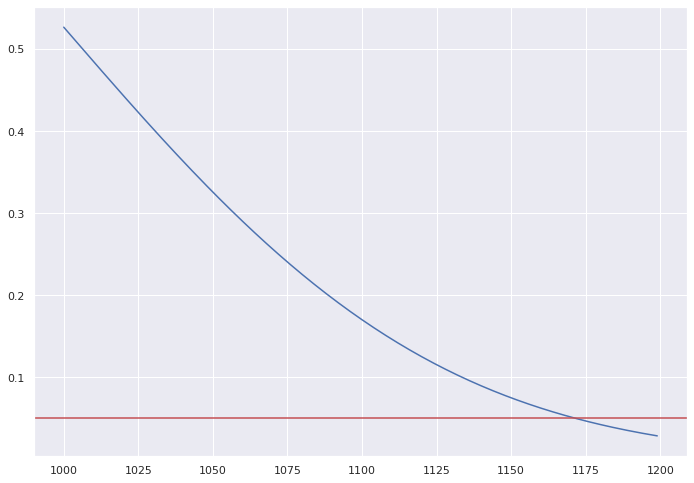

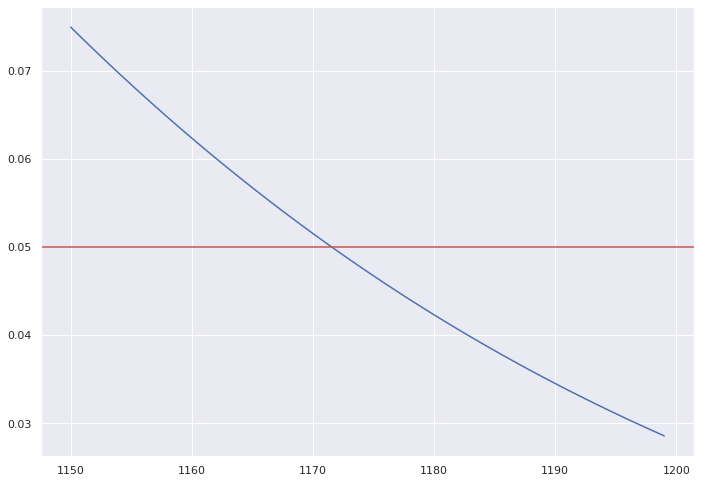

In [33]:
# Используем биноминальное распределение и перебором найдем подходящее число, затем построим график:
st.binom.cdf(100,1170,0.1)
x=[st.binom.cdf(100, c, 0.1) for c in range(1000, 1200)]
plt.plot(range(1000, 1200), x)

# Красной линией изобразим вероятность не выполнить план
plt.axhline(y = 0.05, color = 'r', linestyle = '-')
plt.show()

# Построим график для нахождения более точного искомого значения:
x=[st.binom.cdf(100, c, 0.1) for c in range(1150, 1200)]
plt.plot(range(1150, 1200), x)
plt.axhline(y = 0.05, color = 'r', linestyle = '-')
plt.show()


Вероятность оказаться ниже порогового значения 0,05 достигается примерно при 1172 промокодов. 
Как минимум 1172 промокода необходимо раздать, чтобы вероятность не выполнить план была примерно 5%.

**Задача 7.2**
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [34]:
# Задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399500 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


Вероятность того, что уведомление откроют не более 399500 пользователей составляет около 15,4%. Теперь построим примерный график распределения.

In [35]:
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

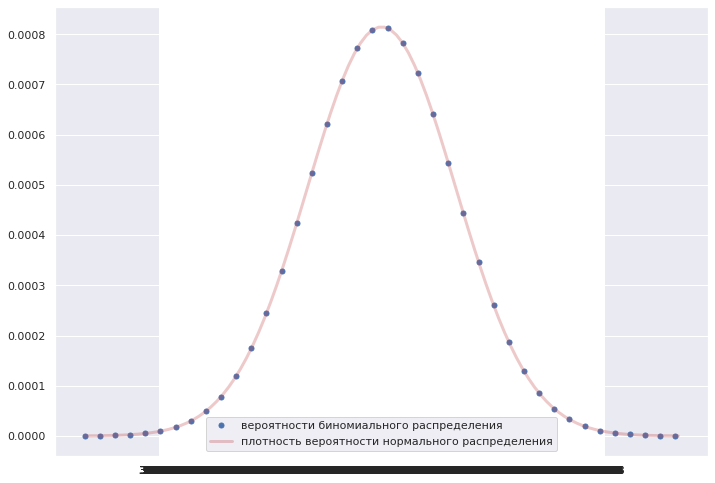

Условие выполняется


In [36]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right, 100))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, st.binom.pmf(x, n, p), 'bo', ms=5,
	      label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, st.norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Биномиальное распределение достаточно симметрично, чтобы аппроксимировать его нормальным.

# Вывод

В данной работе мы исследовали данные сервиса аренды самокатов GoFast за 2021 год. В состав данных вошли сведения о пользователях услуг (их имена, возраст, город, тип подписки), а также информация об их поездках (продолжительность, расстояние 1 совершенной поездки, дата поездки).

>На Шаге 1 мы испортировали все необходимые для конкретного анализа данных библиотеки, считали предоставленные CSV-файлы с данными с помощью библиотеки Pandas и сохранили их в датафреймы. Затем выведили первые несколько строк каждого набора данных. Изучив общую информацию о каждом датафрейме, убедились, что необходима предобработка некоторых данных и перешли к Шагу 2.

>На Шаге 2 мы привели столбец `date` к типу даты Pandas; создали новые столбцы с номером месяца и годом на основе столбца `date`, а также обработали дубликаты и проверили наши датасеты на предмет наличия пропусков (пропусков не оказалось нигде, а все явные дубликаты (31 штука) были удалены).

>На Шаге 3 мы перешли к исследовательскому анализу данных и постарались визуализировать информацию, изобразив графики частоты встречаемости городов; соотношения пользователей с подпиской и без подписки; возраста пользователей; расстояния, которое пользователь преодолел за одну поездку; продолжительности поездок. Получили следующие выводы: 

услуги оказались наиболее популярны в Пятигорске, а наименее популярны в Москве;

чаще встречаются пользователи без подписки и их более 800, а пользователей с подпиской около 700;

наиболее популярны услуги GoFast среди пользователей чуть старше 20 и немного моложе 30 лет; особо популярны услуги среди пользователей возрастом примерно 25 лет;

в основном услугами пользуются для преодоления расстояния от примерно 2,5 до 4 км;

наиболее часто встречающаяся продолжительность поездок в нашей выборке находится в диапазоне от более 10 до менее 25 минут.

>На Шаге 4 мы объединили данные о пользователях, поездках и подписках в один датафрейм с помощью метода `merge`. Затем мы создали еще два датафрейма с данными о пользователях без подписки и данными о пользователях с подпиской. После этого мы визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий и получили следующие выводы:

пользователей без подписки в основном пользуются услугами для преодоления расстояния от 2 до чуть менее 4,5 км. Аналогичный показатель для пользователей с подпиской: от чуть более 2,5 до примерно 3,5 км;

наиболее часто встречающиеся значения по времени сессии среди пользователей без подписки находятся в диапазоне примерно от 10 до 25 минут;
а среди пользователей с подпиской - в диапазоне примерно от чуть более 10 до чуть менее 25 минут. В отличие от первой категории, есть пользователи, время сессии которых превысило 35 минут, но относительно нашей выборки их очень мало.

>На Шаге 5 с помощью группировки с `pivot.table()` мы создали датафрейм с агрегированными данными о поездках с суммарным расстоянием, количеством поездок и суммарным время для каждого пользователя за каждый месяц. В этот же датафрейм мы добавили столбец с помесячной выручкой, которую принёс каждый пользователь, обратившись для этого к изначально предоставленной информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Такие датафреймы мы создавали для проверки дальнейших гипотез на Шаге 6.

>На Шаге 6 нам была дана следующая установка: продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов, а именно:

проверить, тратят ли пользователи с подпиской больше времени на поездки;

можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (оптимальное  расстояние одной поездки на самокате с точки зрения его износа);

проверить гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

> Вот, что удалось выяснить после выполнения статистических тестов:

есть основания говорить о том, что пользователи с подпиской тратят больше времени на поездки в среднем на одну поездку;

есть основания полагать, что среднее расстояние пользователей с подпиской за одну поездку не превышает оптимальное 3130 метров;

есть основания полагать, что пользователи с подпиской приносят бОльшую ежемесячную выручку.

> На Шаге 7 перед нами был поставлен следующий вопрос: какое минимальное количество промокодов на один бесплатный месяц подписки нужно разослать, чтобы вероятность не выполнить план по переходу 100 существующими пользователями на платную подписку была примерно 5% (при этом мы знаем, что эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей). 

Использовав биноминальное распределение (подобрав значение вручную и построив график), мы выяснили, что как минимум 1172 промокода необходимо раздать, чтобы вероятность не выполнить вышеупомянутый план была примерно 5%.

> На Шаге 7 мы также попытались с помощью аппроксимации построить примерный график распределения и оцените вероятность того, что push-уведомления, которые отдел маркетинга планирует разослать в мобильном приложении в объеме 1 млн, откроют не более 399,5 тыс. пользователей (при этом известно, что уведомления открывают около 40 % получивших клиентов). Получили следующий покатель:

вероятность того, что уведомление откроют не более 399500 пользователей составляет около 15,4%.